In [4]:
import gzip, struct, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


### 1 – Helper function to read IDX format

In [5]:
import struct, numpy as np

def load_idx(path: str) -> np.ndarray:
    """Load an idx{1,3}-ubyte file (already un-gzipped)."""
    with open(path, 'rb') as f:
        _, _, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

### 2 – Load the data

In [6]:
#  Read images & labels
X_train = load_idx('/content/train-images.idx3-ubyte')
y_train = load_idx('/content/train-labels.idx1-ubyte')
X_test  = load_idx('/content/t10k-images.idx3-ubyte')
y_test  = load_idx('/content/t10k-labels.idx1-ubyte')

print("Shapes ➜", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Shapes ➜ (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### 3 – Flatten images and min-max scale to 0-1

In [7]:

from sklearn.preprocessing import MinMaxScaler

# Reshape: (n_samples, 28, 28)  → (n_samples, 784)
X_train_flat = X_train.reshape(-1, 28*28).astype('float32')
X_test_flat  = X_test.reshape(-1, 28*28).astype('float32')

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

print("After scaling:", X_train_scaled.shape, X_test_scaled.shape)


After scaling: (60000, 784) (10000, 784)


### Train a Random Forest

In [8]:

from sklearn.ensemble import RandomForestClassifier
from time import time

rf = RandomForestClassifier(
        n_estimators=300,      # more trees → slightly better F1
        n_jobs=-1,            # use all CPU cores
        random_state=42
     )

t0 = time()
rf.fit(X_train_scaled, y_train)
print(f"Training finished in {time()-t0:.1f} seconds")


Training finished in 123.4 seconds


### Evaluate on training & test sets

In [9]:

from sklearn.metrics import classification_report, f1_score, confusion_matrix
import pandas as pd

# --- Training metrics
y_tr_pred = rf.predict(X_train_scaled)
train_report = pd.DataFrame(classification_report(
                               y_train, y_tr_pred, output_dict=True)).T
train_f1 = f1_score(y_train, y_tr_pred, average='macro')

# --- Test metrics
y_te_pred = rf.predict(X_test_scaled)
test_report = pd.DataFrame(classification_report(
                              y_test, y_te_pred, output_dict=True)).T
test_f1 = f1_score(y_test, y_te_pred, average='macro')

print(f"Macro F1  →  Train: {train_f1:.4f} | Test: {test_f1:.4f}")
train_report


Macro F1  →  Train: 1.0000 | Test: 0.9713


,precision,recall,f1-score,support
0,1.0,1.0,1.0,5923.0
1,1.0,1.0,1.0,6742.0
2,1.0,1.0,1.0,5958.0
3,1.0,1.0,1.0,6131.0
4,1.0,1.0,1.0,5842.0
5,1.0,1.0,1.0,5421.0
6,1.0,1.0,1.0,5918.0
7,1.0,1.0,1.0,6265.0
8,1.0,1.0,1.0,5851.0
9,1.0,1.0,1.0,5949.0


### Plot confusion matrices

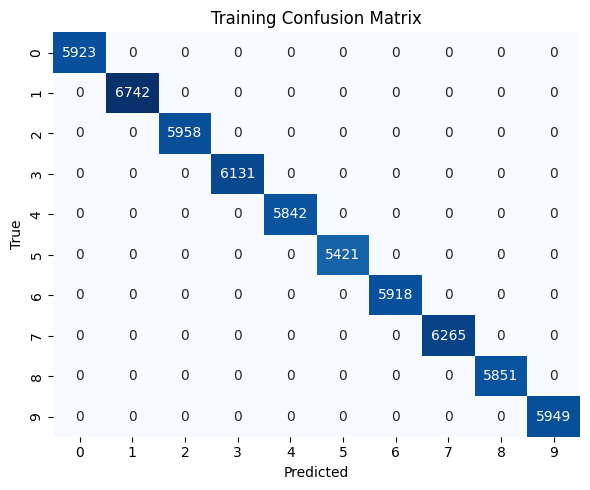

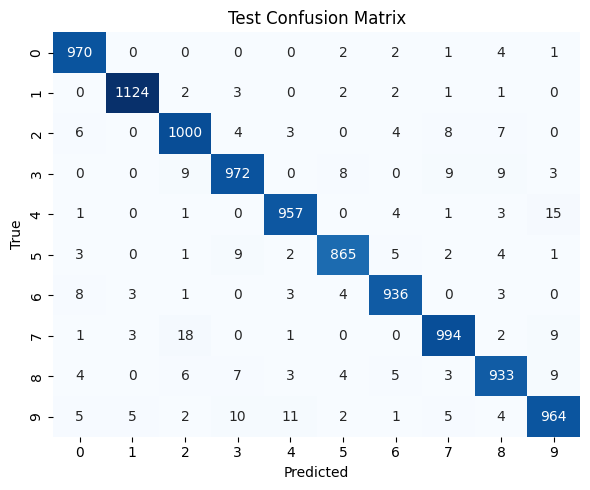

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cm(cm, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title); plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout()

plot_cm(confusion_matrix(y_train, y_tr_pred), "Training Confusion Matrix")

plot_cm(confusion_matrix(y_test,  y_te_pred), "Test Confusion Matrix")

In [11]:
# Cell 8 – Overall TP / FP / FN / TN and aggregated metrics  (no per-digit list)

import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Compute confusion-matrix without specifying labels → uses all present classes
cm = confusion_matrix(y_test, y_te_pred)
total_samples = cm.sum()

# Overall counts (micro-averaged)
TP = np.trace(cm)                           # sum of diagonal
FP = cm.sum(axis=0).sum() - TP              # all column sums minus TP
FN = cm.sum(axis=1).sum() - TP              # all row sums minus TP
TN = total_samples - (TP + FP + FN)

# Sanity check
assert TP + FP + FN + TN == total_samples

# Build results table
overall_table = pd.DataFrame({
        "Metric": ["True Positive", "False Positive", "False Negative", "True Negative"],
        "Count" : [TP, FP, FN, TN]
})

# Overall scores (micro = same as accuracy for multi-class)
accuracy  = accuracy_score(y_test, y_te_pred)
precision = precision_score(y_test, y_te_pred, average='micro')
recall    = recall_score(y_test, y_te_pred, average='micro')
f1        = f1_score(y_test, y_te_pred, average='micro')

display(overall_table.style.set_caption("Aggregate Confusion-Matrix Counts"))
print(f"\n⚙️  Overall metrics  →  "
      f"Accuracy: {accuracy:.4f}  |  Precision: {precision:.4f}  |  "
      f"Recall: {recall:.4f}  |  F1: {f1:.4f}")


,Metric,Count
0,True Positive,9715
1,False Positive,285
2,False Negative,285
3,True Negative,-285



⚙️  Overall metrics  →  Accuracy: 0.9715  |  Precision: 0.9715  |  Recall: 0.9715  |  F1: 0.9715


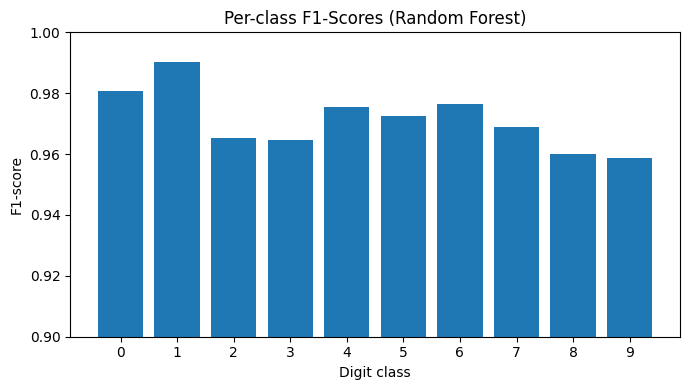

In [12]:
from sklearn.metrics import  classification_report

report = classification_report(y_test, y_te_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(10)]

plt.figure(figsize=(7,4))
plt.bar(range(10), f1_scores)
plt.xticks(range(10))
plt.ylim(0.9, 1.0)
plt.ylabel("F1-score")
plt.xlabel("Digit class")
plt.title("Per-class F1-Scores (Random Forest)")
plt.tight_layout()
plt.show()

In [13]:
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# find indices of five largest off-diagonal counts
flat_idx = np.argsort(cm_no_diag, axis=None)[-5:]
rows, cols = np.unravel_index(flat_idx, cm_no_diag.shape)
mis_pairs = [(r, c, cm_no_diag[r, c]) for r, c in zip(rows, cols)]
mis_pairs.sort(key=lambda x: x[2], reverse=True)   # descending

print("\nTop-5 misclassifications:")
for r, c, n in mis_pairs:
    print(f"Digit {r} → {c}: {n} samples")


Top-5 misclassifications:
Digit 7 → 2: 18 samples
Digit 4 → 9: 15 samples
Digit 9 → 4: 11 samples
Digit 9 → 3: 10 samples
Digit 7 → 9: 9 samples


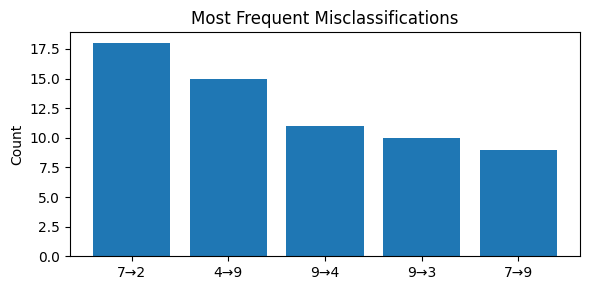

In [16]:
if mis_pairs[0][2] > 0:          # only plot if there are mistakes
    labels = [f"{r}→{c}" for r, c, _ in mis_pairs]
    counts = [n for _, _, n in mis_pairs]

    plt.figure(figsize=(6,3))
    plt.bar(labels, counts)
    plt.ylabel("Count")
    plt.title("Most Frequent Misclassifications")
    plt.tight_layout()
    plt.show()